## Sentiment Analysis on  [Twitter US Airline](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) data

The Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets regarding major U.S. airlines.

**Imports**

In [1]:
import os
import random
import io
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import nltk
import numpy
nltk.download('punkt')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# Upload training data and test data to google colab
from google.colab import files
dataset = files.upload()

Saving tweet.csv to tweet.csv


**Functions**

In [0]:
def read_in(path_to_file):
    out = []
    with open(path_to_file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader)
        for row in csv_reader:
            if row[1] == "negative":
                out.append([-1, row[10]])
            elif row[1] == "neutral":
                out.append([0, row[10]])
            elif row[1] == "positive":
                out.append([1, row[10]])
        random.shuffle(out)
    return out

  
def preprocess(data):
    """
    Preprocesses and tokenizes data
    """
    label = []
    tweet = []
    print("Preprocessing...")
    for row in data:
        cleaned = clean_regex(row[1].lower())
        if cleaned.__len__() > 1:
            tokenized = nltk.word_tokenize(cleaned)
            # pos_tagged = nltk.pos_tag(tokenized)
            tweet.append(tokenized)
            label.append(row[0])
    print("Done")
    return tweet, label


def clean_regex(tweet):
    """
    Regex that removes links to other users, and all hyperlink mentions
    """
    cleaned = re.sub('@.*?(?:\s|$)', '', tweet)
    cleaned2 = re.sub('http.*?(?:\s|$)', '', cleaned)
    cleaned3 = re.sub('www.*?(?:\s|$)', '', cleaned2)
    cleaned4 = re.sub('#','', cleaned3)
    return cleaned4

def parse_to_dict(file_path):
    """
    Creates hashmap with word as key and concept vector as value
    :param file_path: path to the conceptnet dictionary file
    :return: hashmap of word and vectors
    """
    concept_hash = {}
    with open(file_path, encoding="utf8") as f:
        text = f.readlines()[1:]
        for line in text:
            first_item = line.split(" ").__getitem__(0)
            concept_hash[first_item] = line
    f.close()
    return concept_hash

def find_word(word, concept_hash):
    """
    Finds conceptnet vector for a word in the conceptnet hashmap
    :param word: input word to analyze
    :param concept_hash: hashmap of word and conceptnet vector
    :return: returns the appropriate vector or none if its not in the hashmap
    """
    if word in concept_hash.keys():
        vector = concept_hash[word].split(" ")[1:]
        vector = [float(i) for i in vector]
    else:
        vector = None
    return vector
  
def get_embeddings(sentences, max_words=35):
    """
    Retrieves a 300 dim. embedding vector from ConceptNet for each word 
    of a sentence. (Only retrieves the first max_words words (tokens) of a tweet)
    """
    results = np.zeros((len(sentences), max_words, 300))
    for i, sent in enumerate(sentences):
        if i % 1000 == 0:
            print(str(i))
        for j, word in enumerate(sent):
            if j < max_words:
                embedding = find_word(word.lower(), concept_hash)
                if embedding is not None:
                    for k, val in enumerate(embedding):
                        results[i][j][k] = val
                else:
                    for k in range(300):
                        results[i][j][k] = 0.0
    return results

def fill_list(data, max_words=35):
  """
  Fills or cuts list of tokens for a tweet at maxdim, to ensure consistent vector dimensions
  """
  res = []
  for row in data:
      copy = row
      if len(row) < max_words:
          copy += [''] * (max_words - len(row))
      elif len(row) > max_words:
          copy = row[:max_words]   
      res.append(copy)
  return res

def label_conversion(label_data):
  """
  Converts label to normalized value
  """
  out = numpy.zeros(shape=(label_data.__len__(),3), dtype="int8")
  for i, label in enumerate(label_data):
      if label == -1:
          out[i][0] = 1
      elif label == 0:
          out[i][1] = 1
      elif label == 1:
          out[i][2] = 1
  return out



**Preprocessing**

In [5]:
data, label = preprocess(read_in('tweet.csv'))

Preprocessing...
Done


**Split into training and validation set**

In [0]:
# Split training and test data
split_test = 14000
training_data = data[:split_test]
training_label = label[:split_test]
test_data = data[split_test:]
test_label = label[split_test:]

# Split training data into training and validation data
split_val = 11000
train_data = training_data[:split_val]
train_label = np.asarray(training_label[:split_val])
val_data = training_data[split_val:]
val_label = np.asarray(training_label[split_val:])

# Convert labels
test_label= label_conversion(test_label)
train_label = label_conversion(train_label)
val_label = label_conversion(val_label)

**Download ConceptNet word embeddings and load into RAM**

In [0]:
file = !wget https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-en-17.06.txt.gz
import gzip
import shutil
with gzip.open("numberbatch-en-17.06.txt.gz",'rb') as f_in:
    with open('numberbatch-en.txt','wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
concept_hash = parse_to_dict("numberbatch-en.txt")

**Download ELMo word embeddings and load into RAM**

In [8]:
!git clone https://github.com/HIT-SCIR/ELMoForManyLangs
# install pytorch and allennlp (requirement for elmo)
!pip3 install torch torchvision
!pip install allennlp


Cloning into 'ELMoForManyLangs'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 174 (delta 0), reused 2 (delta 0), pack-reused 171
Receiving objects: 100% (174/174), 86.67 KiB | 1.81 MiB/s, done.
Resolving deltas: 100% (85/85), done.
     |████████████████████████████████| 5.7MB 1.4MB/s 
     |████████████████████████████████| 1.9MB 32.4MB/s 
     |████████████████████████████████| 61kB 19.9MB/s 
     |████████████████████████████████| 51kB 18.7MB/s 
     |████████████████████████████████| 256kB 41.2MB/s 
     |████████████████████████████████| 225kB 40.6MB/s 
     |████████████████████████████████| 245kB 38.6MB/s 
     |████████████████████████████████| 133kB 41.7MB/s 
     |████████████████████████████████| 51kB 19.5MB/s 
     |████████████████████████████████| 5.7MB 28.9MB/s 
     |████████████████████████████████| 655kB 38.7MB/s 
  Created wheel for numpydoc: filename=numpydoc-0.9.1-cp

In [9]:
%cd ELMoForManyLangs/
!python setup.py install
!wget http://vectors.nlpl.eu/repository/11/144.zip
!unzip 144.zip

/content/ELMoForManyLangs
running install
running bdist_egg
running egg_info
creating elmoformanylangs.egg-info
writing elmoformanylangs.egg-info/PKG-INFO
writing dependency_links to elmoformanylangs.egg-info/dependency_links.txt
writing requirements to elmoformanylangs.egg-info/requires.txt
writing top-level names to elmoformanylangs.egg-info/top_level.txt
writing manifest file 'elmoformanylangs.egg-info/SOURCES.txt'
writing manifest file 'elmoformanylangs.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/elmoformanylangs
copying elmoformanylangs/frontend.py -> build/lib/elmoformanylangs
copying elmoformanylangs/elmo.py -> build/lib/elmoformanylangs
copying elmoformanylangs/__init__.py -> build/lib/elmoformanylangs
copying elmoformanylangs/biLM.py -> build/lib/elmoformanylangs
copying elmoformanylangs/utils.py -> build/lib/elmoformanylangs
copying elmoformanylangs/data

In [13]:
%rm config.json
# Upload customized config.json and cnn_50_100_512_4096_sample.json
from google.colab import files
files.upload()

Saving cnn_50_100_512_4096_sample.json to cnn_50_100_512_4096_sample (1).json
Saving config.json to config.json


{'cnn_50_100_512_4096_sample.json': b'{\r\n"encoder": {\r\n"name": "elmo",\r\n"projection_dim": 512,\r\n"cell_clip": 3,\r\n"proj_clip": 3,\r\n"dim": 4096,\r\n"n_layers": 2\r\n},\r\n\r\n"token_embedder": {\r\n\t"name": "cnn",\r\n\t"activation": "relu",\r\n\t"filters": [[1, 32], [2, 32], [3, 64], [4, 128], [5, 256], [6, 512], [7, 1024]],\r\n\t"n_highway": 2,\r\n\t"word_dim": 100,\r\n\t"char_dim": 50,\r\n\t"max_characters_per_token": 50\r\n},\r\n\r\n"classifier": {\r\n\t"name": "sampled_softmax",\r\n\t"n_samples": 8192\r\n},\r\n"dropout": 0.1\r\n}',
 'config.json': b'{"seed": 1, "gpu": 3, "train_path": "/users4/conll18st/raw_text/English/en-20m.raw", "valid_path": null, "test_path": null, "config_path": "cnn_50_100_512_4096_sample.json", "word_embedding": null, "optimizer": "adam", "lr": 0.001, "lr_decay": 0.8, "model": "/users4/conll18st/elmo/src/final_models/en.model", "batch_size": 32, "max_epoch": 10, "clip_grad": 5, "max_sent_len": 20, "min_count": 3, "max_vocab_size": 150000, "save_

In [0]:
from elmoformanylangs import Embedder
e = Embedder('.')

**Retrieve word embedding vectors for training and validation data**

In [0]:
# ElMo
train_embedding_matrix = np.asarray(e.sents2elmo(fill_list(train_data)))
val_embedding_matrix = np.asarray(e.sents2elmo(fill_list(val_data)))

In [15]:
# ConceptNet
train_embedding_matrix = get_embeddings(train_data)
val_embedding_matrix = get_embeddings(val_data)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000


**Neural Network Model**

Sequential model with three Dense Layers and one Flatten layer to flatten 3D input matrix.
*Relu* as activation function and simple *sigmoid* function for the output layer. Because of the binary classification task we used a simple *accuracy* metric and *binary crossentropy* as loss function. As optimizer we used *rmsprop*, which performed best according to some tests.

In [22]:
model = models.Sequential()
model.add(layers.Dense(35, activation='relu', input_shape=(35,300,)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.01))
model.add(layers.Dense(35, activation='relu'))
model.add(layers.Dropout(0.01))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
history = model.fit(train_embedding_matrix,
                    train_label,
                    epochs=10,
                    batch_size=256,
                    validation_data=(val_embedding_matrix, val_label), verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 35, 35)            10535     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1225)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1225)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 35)                42910     
_________________________________________________________________
dropout_8 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 108       
Total params: 53,553
Trainable params: 53,553
Non-trainable params: 0
_________________________________________________________________
None
T

**Plotting accuracy and loss in the training phase**

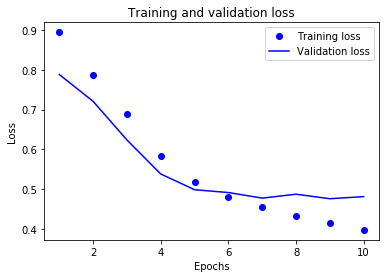

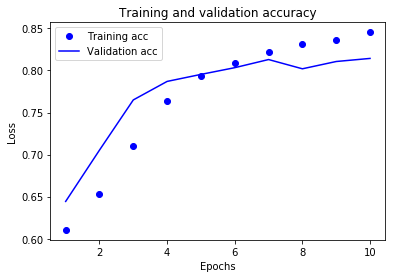

In [23]:
# Loss plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Evaluating model on test data**

In [24]:
# ConceptNet
test_embedding_matrix = get_embeddings(test_data)
# ELMo
#test_embedding_matrix = np.asarray(e.sents2elmo(fill_list(test_data)))

results = model.evaluate(test_embedding_matrix, test_label)
print("Loss: ", results[0])
print("Accuracy: ", results[1])

0
639/639 [==============================] - 0s 118us/step
Loss:  0.470142383484027
Accuracy:  0.8247261347718455


**Results**

We trained our network on 14.000 samples and used the word embedding vectors obtained by ConceptNet and ELMo. We outperform [state-of-the-art approaches](https://ieeexplore.ieee.org/abstract/document/8377739)  with an accuracy of 82.4%.